# Welcome
Let's learn some vectorsearch!


# Setup

In [38]:
#@title Install Dependencies

%%capture
!pip install cassandra-driver ipywidgets


### Setup our AstraDB Connection

1. If you haven't, please [create an AstraDB instance with vector enabled](https://docs.datastax.com/en/astra-serverless/docs/vector-search/overview.html).

1. [Download a copy of your secure connect bundle](https://docs.datastax.com/en/astra-serverless/docs/connect/secure-connect-bundle.html). Then Upload your secure connect bundle to this space by using the file tab.

1. [Create a token for a 'Database Administrator' account](https://docs.datastax.com/en/astra-serverless/docs/manage/org/managing-org.html#_manage_application_tokens), you'll need to be able to create tables and read write data as we go along.



In [11]:
# Replace these values with the path to your secure connect bundle and the database credentials
SECURE_CONNECT_BUNDLE_PATH = '/content/secure-connect-vector-search-db.zip'
ASTRA_CLIENT_ID = '' #@param {type:"string"}
ASTRA_CLIENT_SECRET = '' #@param {type:"string"}


import os
import pandas as pd #just using this for ipy output formating
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from cassandra import ConsistencyLevel
from cassandra.query import dict_factory

cloud_config = {
   'secure_connect_bundle': SECURE_CONNECT_BUNDLE_PATH
}
auth_provider = PlainTextAuthProvider(ASTRA_CLIENT_ID, ASTRA_CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider, protocol_version=4)
session = cluster.connect()


# Load some vector data and perform our first search

## Setup our schema and index

In [ ]:
KEYSPACE_NAME = 'vsearch'
TABLE_NAME = 'products'
#session.row_factory = dict_factory

print(f"Creating table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"CREATE TABLE IF NOT EXISTS {KEYSPACE_NAME}.{TABLE_NAME} (id int PRIMARY KEY, name TEXT, description TEXT, item_vector VECTOR<FLOAT, 5>)")

print(f"Creating index ann_index on table {TABLE_NAME} and inserting example data")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ann_products_index ON {KEYSPACE_NAME}.{TABLE_NAME}(item_vector) USING 'StorageAttachedIndex'")



## Load Some Data



In [13]:
product_data = [
    (1, 'Coded Cleats', 'ChatGPT integrated sneakers that talk to you', [0.1, 0.15, 0.3, 0.12, 0.05]),
    (2, 'Logic Layers', 'An AI quilt to help you sleep forever', [0.45, 0.09, 0.01, 0.2, 0.11]),
    (5, 'Vision Vector Frame', 'A deep learning display that controls your mood', [0.1, 0.05, 0.08, 0.3, 0.6])
]

for product in product_data:
    session.execute(f"INSERT INTO {KEYSPACE_NAME}.{TABLE_NAME} (id, name, description, item_vector) VALUES {product}")

## Our first Vector Search!

In [ ]:
query = f"SELECT name, description, item_vector FROM {KEYSPACE_NAME}.{TABLE_NAME} ORDER BY item_vector ANN OF [0.15, 0.1, 0.1, 0.35, 0.55] LIMIT 1"

pd.DataFrame(list(session.execute(query)))


# Building our own vectors

Let's do something more interesting with vector search.

In the following section we are going to build and image-to-image search based on:

* a public image model (ViT)
* a publicly available image dataset
* AstraDB's vectorDB

We will:

1. setup our environment
1. download an image dataset
1. normalize all the photos from our dataset
1. process them to extract a vector
1. Add them to a table in our vector db
1. Use a fresh image to search our db for similar pictures

ref: [Unofficial Walkthrough of Vision Transformer](https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb#scrollTo=y_uWXBvo1X1C)

## Setup our environment

**timm** is used to download existing models from Huggingface.co

**datasets** and **datasets[vision]** are used to download example datasets from huggingface. After we are done here, why not pick a different dataset and try it for yourself? [This section of the huggingface shared datasets](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads) is a good place to start.

In [15]:
%%capture
!pip install timm
!pip install datasets
!pip install datasets[vision]
!pip install ipyplot
print("[1;32mDone")

## Grab some libraries Python will need

**torchvision** will be used to process images and normalizet them.

**PIL** till be used to load images and display them in this workbook.

In [33]:
%%capture
import torch

import torchvision
import torchvision.transforms as T

import PIL
import ipyplot

from timm import create_model

print("[1;32mDone")

## Grab our dataset

[Explore the dataset here](https://huggingface.co/datasets/Matthijs/snacks/viewer/default/train)


Want to try with another dataset? It should be as easy as making sure that dataset has an "image" property that we can load.

If it's hosted on huggingface, you can also just change the string below to load it. (like docker, but data!)

In [ ]:
from datasets import load_dataset, Image

dataset = load_dataset("Matthijs/snacks")

## The Good Stuff

Let's grab a public model to handle creating vectors from our images. I'm using "vit_base_patch16_224" but there are lots of options.

A couple things to keep in mind as you pick pre-existing models
* Which other models work best for your task before any additional training?
* How do the models perform, is a faster but less effective model good enough?

We are also setting up the GPU for use if it's available. Currently, most models really want a GPU to perform reasonabily. That may change in the near-ish future.

Lastly. we grab a copy of the pretrained model and then load it into our GPU (if available).

In [ ]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

## Normalize our data

It's important that our images are formatted similarly for most models if we hope to compare our apples to our oranges.

These steps setup a pipeline to resize images, convert them to a tensor to feed to our model, and normalize that tensor.

In [19]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

def ds_transforms(examples):
    examples["pixel_values"] = [transforms(image) for image in examples["image"]]
    return examples

dataset = dataset.with_transform(ds_transforms)

## Let's test what we've got so far

Let's also look at a row from the dataset that we have downloaded. Notice that our transforms have run and we now have a pixel_values field with a normalized and version of our image ready for processing.

In [ ]:
i = dataset["train"][10]
print("an image from the dataset")
display(i)

The following code loads an entry from the training data, uploads it's image data to our GPU and then runs our model on it.

VOILA! We have a vector! (though we are still calling it a tensor)



In [ ]:
img_tensor = i["pixel_values"].unsqueeze(0).to(device)
output = model(img_tensor)
output

## We need to get Vectors for all our images in the dataset

Below we are going to embed the vector/tensor result from the model into our dataset.

NOTE: We also create an index for each row in the dataset. That index is used to get back image data after our search. In the real world your data would probably already have some sort of unique id and this approach to id generation would never be a good idea.

In [22]:
def add_embedding(example, idx):
  example["id"] = idx # adding the index to the dataset here
  with torch.no_grad(): # pytorch likes to keep data about the model run, we will run out of memory if we leave this on.
    example["embedding"] = model(example["pixel_values"].unsqueeze(0).to(device)) # analyze the image data, and copy the vector embedding back to system memory
  return example


updated_dataset = dataset.map(add_embedding, with_indices=True)

Map:   0%|          | 0/4838 [00:00<?, ? examples/s]

Map:   0%|          | 0/952 [00:00<?, ? examples/s]

Map:   0%|          | 0/955 [00:00<?, ? examples/s]

### What is a vector/tensor?

This densely packed array of numbers is the result of our model examining the image data and rating it against various features created during training.

What are those features? We don't know, but they aren't colors at a specific pixel or filesizes.

One way to think about vector creation is that those 1000 numbers represent the types of differences our model experienced between images when it was trained.

## Saving our embeddings to AstraDB

This sets up our AstraDB database to store images in the 'images' table and creates a custom index to enable searching by vectors against the 'images' table.

In [ ]:
KEYSPACE_NAME = 'vsearch'
TABLE_NAME = 'images'

#session.execute(f"DROP TABLE {KEYSPACE_NAME}.{TABLE_NAME}")
print(f"Creating table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"CREATE TABLE IF NOT EXISTS {KEYSPACE_NAME}.{TABLE_NAME} (id int PRIMARY KEY,  image_vector VECTOR<FLOAT, 1000>)")

print(f"Creating index ann_index on table {TABLE_NAME} and inserting example data")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ann_index ON {KEYSPACE_NAME}.{TABLE_NAME} (image_vector) USING 'StorageAttachedIndex'")

In [ ]:
def insert_embedding(example):
  id = example["id"]
  embedding = example["embedding"][0]
  session.execute(f"INSERT INTO {KEYSPACE_NAME}.{TABLE_NAME}  (id, image_vector) VALUES ({id}, {embedding})")
  return example

updated_dataset.map(insert_embedding)

## Let's search some Images!

Let's pretend to upload an image to your cool new image-to-image search app. Fortunately, we have a bunch of images that weren't embedded into our vector DB in our "test" and "validate" datasets. So we can pretend one of those images has been submitted by a user in order to query our vector db.

We can grab an image from there, calculate it's embeddings and then ask the database for similar images.

Our test set is 952 images, so set the 'search_id' below to some number between 0 and 952.



Searching for images like this one:


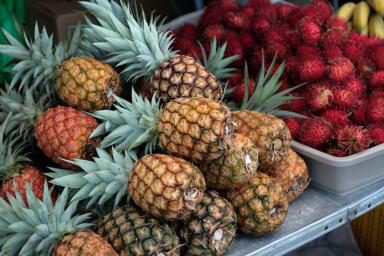

Returning 'nearest neighbor' using ANN search



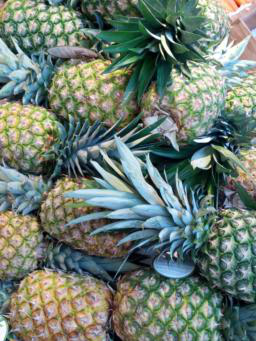
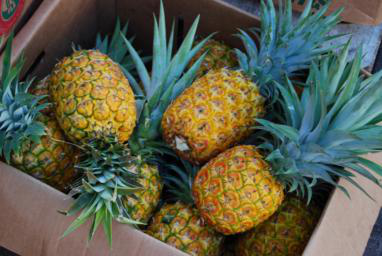
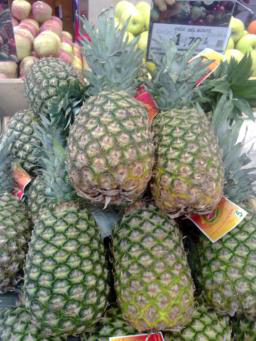
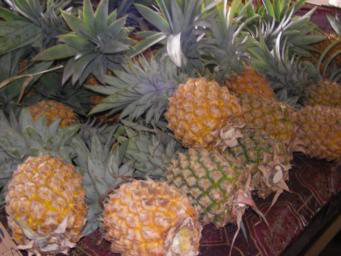
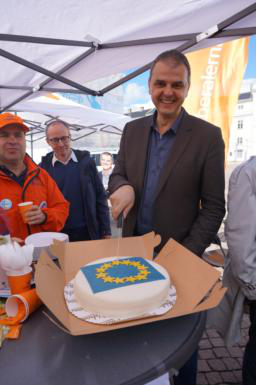


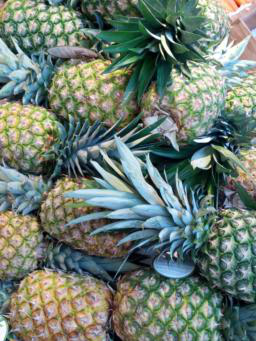
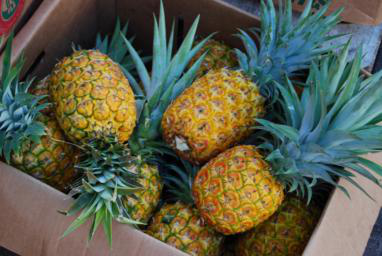
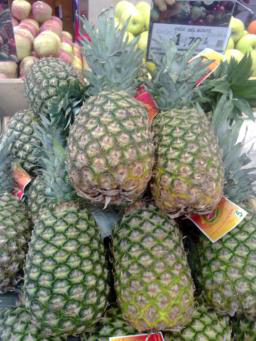
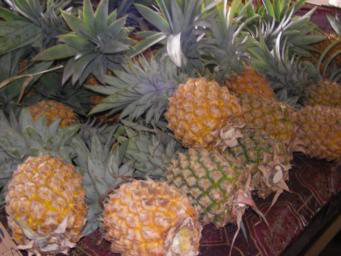
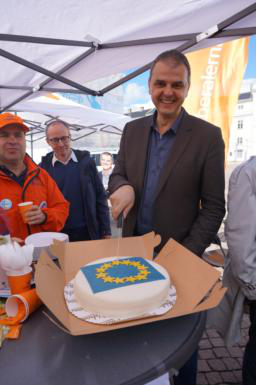

In [32]:
# our test dataset has 952 images, pick a number to try a different search
search_id = 655 #@param {type:"integer"}

# grab an image from out test set (remember, these images are not in our DB)
img = updated_dataset["test"][search_id]
print("Searching for images like this one:")
display(img["image"])
embedding = img["embedding"][0]

images = []
labels = []
KEYSPACE_NAME = 'vsearch'
TABLE_NAME = 'images'
# use that embedding as a query
print(f"Returning 'nearest neighbor' using ANN search")
for row in session.execute(f"SELECT id, image_vector FROM {KEYSPACE_NAME}.{TABLE_NAME} ORDER BY image_vector ANN OF {embedding} LIMIT 5"):
  image = updated_dataset["train"][row.id]
  images.append(image["image"])
  labels.append(row.id)

#display our images in a pretty grid
ipyplot.plot_images(images, labels, img_width=300)


# Next Steps

The road branches here, do you want to:

* Learn more about vectors and what you can do with them?
https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings

* Coffee talk with data scientists (and understand some of the magic)?
https://developers.google.com/machine-learning/crash-course/

* Embed two sets of vectors into the same space? Ratings + Users anyone?
https://cloud.google.com/blog/products/ai-machine-learning/scaling-deep-retrieval-tensorflow-two-towers-architecture

* Learn about AstraDB/Apache Cassandra as a tool in awesome new Generative AI agents?
https://cassio.org
